In [3]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

style.use('seaborn-whitegrid')

# Simple Regression

Here we define the squared exponential kernel, which is one the most popular kernel in GP

$$
k(x,x') = \sigma_0^2 \exp \left[ \frac{1}{2} \left(\frac{x - x'}{\lambda}\right)^2 \right]
$$

In [2]:
def squared_exponential(a, b, param):
    a_tile = np.tile(a, [b.shape[0], 1]).T
    b_tile = np.tile(b, [a.shape[0], 1])
    
    cov = a_tile - b_tile
    cov = cov / param['lambda']
    cov = cov*cov
    cov = -0.5 * cov
    cov = np.exp(cov)
    return param['sigma'] * param['sigma'] * cov

To test for the GP implementation, first I try a very simple regression

\begin{equation*}
f(x) = 1 + 0.05x + \frac{\sin (x)}{x} + 0.2 \mathcal{N}(0,1)
\end{equation*}

We use only 100 points as training and use GP to regress the function of 1000 points. For the remainder of this experiment, the zero mean function and squared exponential kernel function is used.

In [17]:
np.random.seed(0)
n = 1000
sample_n = 100

x_ = np.linspace(-10,10,n)
x = np.random.choice(x_, sample_n)
y = 1 + 0.05 * x + np.sin(x) / x + 0.2 * np.random.randn(sample_n)
y_= 1 + 0.05 * x_ + np.sin(x_) / x_ + 0.2 * np.random.randn(n)
y_true = 1 + 0.05 * x_ + np.sin(x_) / x_

The analytic inference of GP can be implemented with just two lines of code. Here the parameter to the kernel is statically defined. In the actual GP implementation, the parameter can be obtained by finding the maximum likelihood.

In [18]:
param = {'lambda': 1, 'sigma': 1}

K = squared_exponential(x, x, param)
K_ = squared_exponential(x, x_, param).T
K__ = squared_exponential(x_, x_, param)

y_star = np.dot(np.dot(K_, np.linalg.inv(K+10e-6 * np.eye(x.size))), y)
cov = K__ - np.dot(np.dot(K_, np.linalg.inv(K+10e-6 * np.eye(x.size))),K_.T)

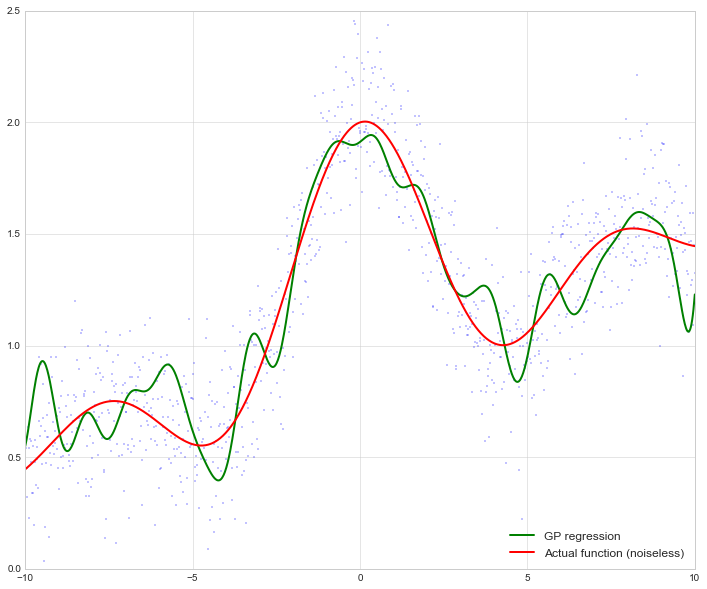

In [19]:
%matplotlib inline
plt.figure(1, figsize=(12,10))
plt.plot(x_,y_, '.', ms=1)
plt.plot(x_, y_star, linewidth=2)
plt.plot(x_, y_true, linewidth=2)
plt.legend(('', 'GP regression', 'Actual function (noiseless)'), loc=4)

If we use 500 points instead for training, the regression becomes more accurate. 

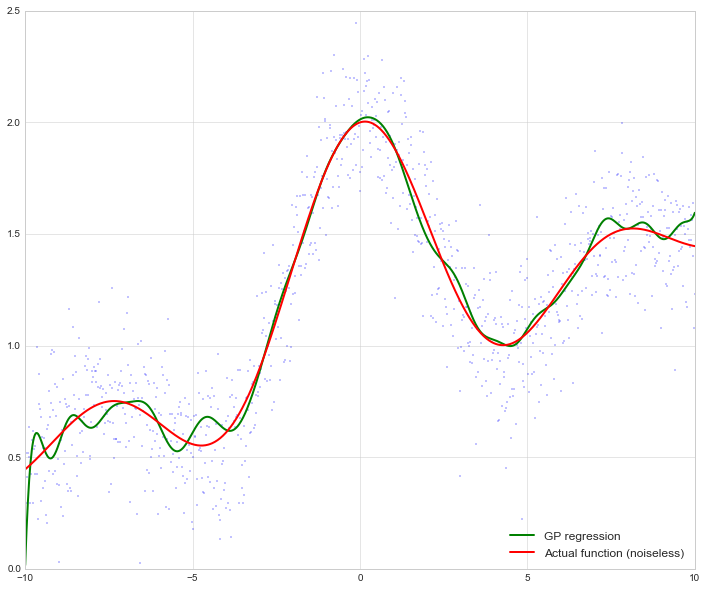

In [21]:
n = 1000
sample_n = 500

x_ = np.linspace(-10,10,n)
x = np.random.choice(x_, sample_n)
y = 1 + 0.05 * x + np.sin(x) / x + 0.2 * np.random.randn(sample_n)
y_= 1 + 0.05 * x_ + np.sin(x_) / x_ + 0.2 * np.random.randn(n)
y_true = 1 + 0.05 * x_ + np.sin(x_) / x_

param = {'lambda': 1, 'sigma': 1}

K = squared_exponential(x, x, param)
K_ = squared_exponential(x, x_, param).T
K__ = squared_exponential(x_, x_, param)

y_star = np.dot(np.dot(K_, np.linalg.inv(K+10e-6 * np.eye(x.size))), y)
cov = K__ - np.dot(np.dot(K_, np.linalg.inv(K+10e-6 * np.eye(x.size))),K_.T)

plt.figure(1, figsize=(12,10))
plt.plot(x_,y_, '.', ms=1)
plt.plot(x_, y_star, linewidth=2)
plt.plot(x_, y_true, linewidth=2)
plt.legend(('', 'GP regression', 'Actual function (noiseless)'), loc=4)

# Weather Data Regression

Previously, the GP is used to regress a simple function, which is why it works great. Now let us see the performance of GP on real data. We are going to do regression on average wind speed over a single day.

/Users/bagas/anaconda/envs/thesis/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


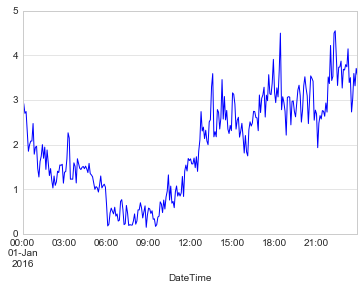

In [23]:
import pandas as pd

data_folder = '../data/weather/'

data = pd.read_csv(data_folder + 'Capelle.csv',
                   parse_dates=['DateTime'],
                   index_col=['DateTime'])

wind_speed = data['WindSpd_{Avg}']
day = wind_speed['2016/1/1'].astype('float')
day.plot()

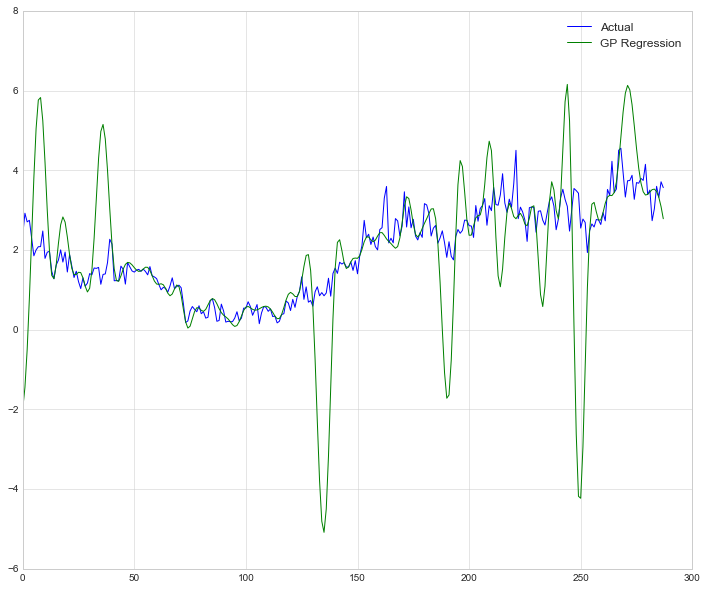

In [25]:
y_ = day.values
x_ = np.arange(y_.size)

sample_n = 100

x = np.random.choice(x_, sample_n)
y = [y_[i] for i in x]

param = {'lambda': 5, 'sigma': 2}

K = squared_exponential(x, x, param)
K_ = squared_exponential(x, x_, param).T
K__ = squared_exponential(x_, x_, param)

y_star = np.dot(np.dot(K_, np.linalg.inv(K+10e-6 * np.eye(x.size))), y)
cov = K__ - np.dot(np.dot(K_, np.linalg.inv(K+10e-6 * np.eye(x.size))),K_.T)

plt.figure(figsize=(12,10))
plt.plot(x_, y_)
plt.plot(x_, y_star)
plt.legend(['Actual', 'GP Regression'])

From the plot we can see that my implementation of GP is affected by the noise (outlier?) which cause the spiky effect to the otherwise sufficient regression. There are several ways to improve this. First is to incorporate noise into the analytic expression of GP.

$$ 
\begin{pmatrix}
\mathbf{y} \\
\mathbf{y}^*
\end{pmatrix} 
\sim \mathcal{N} \left( \begin{pmatrix}
\mathbf{\mu} \\
\mathbf{\mu}^*
\end{pmatrix}, 
\begin{pmatrix}
K & K^* \\
(K^*)^T & K^{**}
\end{pmatrix}
\right)
$$

\begin{align}
\mu^* &= \mu(X^*) + (K^*)^T (K+\sigma^2 I)^{-1} (y - \mu(X)) \\
\Sigma^* &= K^{**} - (K^*)^T (K+\sigma^2 I)^{-1} K^*
\end{align}

Second, minimize the likelihood function with respect to the parameter to get the optimized parameter. Lastly, try out different type of kernel.

# Weather Data Forecast

Here I apply my GP implementation to forecast problem. Given seven days worth of wind speed data, the GP tries to forecast the wind speed for the next whole day. Below is the result. As expected, the result is highly unsatisfactory, thus a better strategy is needed.

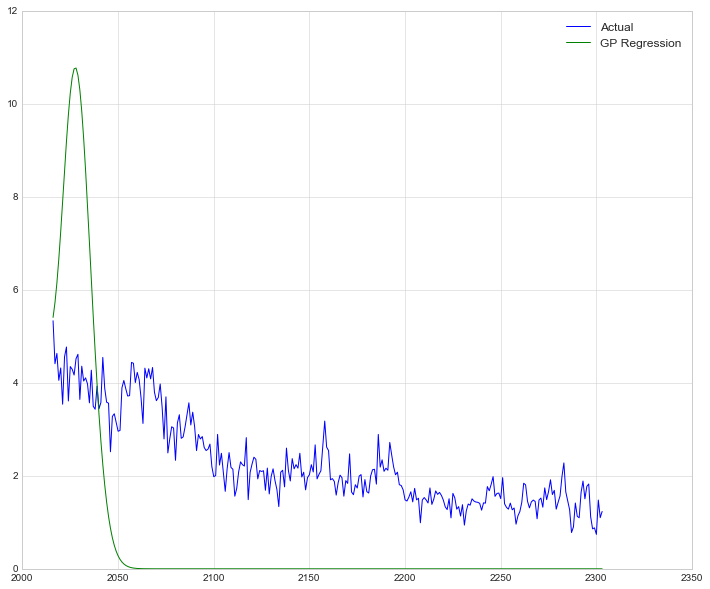

In [34]:
y = wind_speed['2016/1/1':'2016/1/7'].astype('float')
x = np.arange(y.size)

y_ = wind_speed['2016/1/8']
x_ = np.arange(y.size, y.size + y_.size)

param = {'lambda': 10, 'sigma': 0.1}

K = squared_exponential(x, x, param)
K_ = squared_exponential(x, x_, param).T
K__ = squared_exponential(x_, x_, param)

y_star = np.dot(np.dot(K_, np.linalg.inv(K+10e-6 * np.eye(x.size))), y)
cov = K__ - np.dot(np.dot(K_, np.linalg.inv(K+10e-6 * np.eye(x.size))),K_.T)

plt.figure(figsize=(12,10))
plt.plot(x_, y_)
plt.plot(x_, y_star)
plt.legend(['Actual', 'GP Regression'])